# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn import preprocessing
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Understading each dataset

### Profile Dataset

In [2]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [3]:
profile.shape, profile.id.nunique()

((17000, 5), 17000)

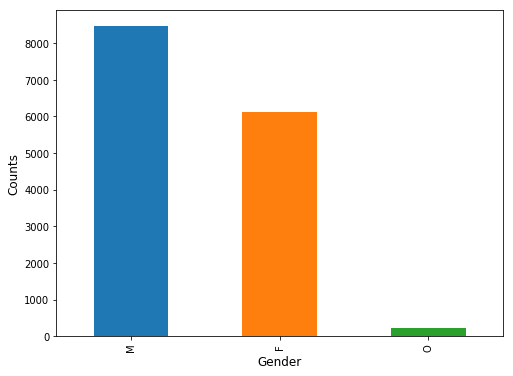

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
profile.gender.value_counts().plot(kind='bar')
ax.set_xlabel("Gender", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);
plt.show()

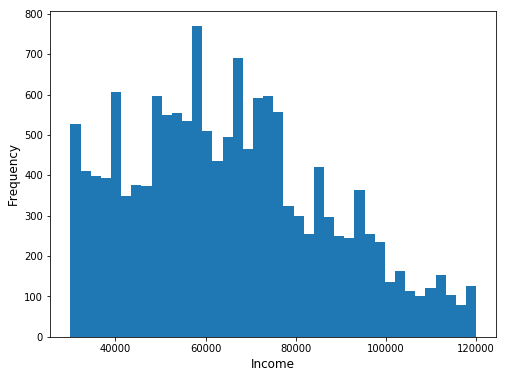

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
profile.income.plot(kind='hist', bins=40)
ax.set_xlabel("Income", fontsize=12);
ax.set_ylabel("Frequency", fontsize=12);
plt.show()

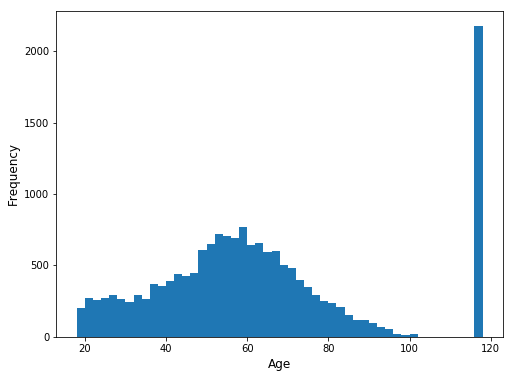

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
profile.age.plot(kind='hist', bins=50)
ax.set_xlabel("Age", fontsize=12);
ax.set_ylabel("Frequency", fontsize=12);
plt.show()

In [7]:
len(profile[profile.age > 100])

2180

In [8]:
profile.shape

(17000, 5)

In [9]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

We have more than 2000 records missing in income and age, and 2000 memmbers above 100 years old, are these the same records?

In [10]:
profile[profile.gender.isnull()].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


Same records have the missing age and gender

In [11]:
profile[profile.gender.isnull()].age.value_counts()

118    2175
Name: age, dtype: int64

All these records has the age of 118, so it seems that either this is a system error or the default when people sign up and it seems as of the age and gender and income are not mandatory, can we drop these records? 

In [12]:
profile.rename(columns={'id':'user_id'}, inplace=True)

In [13]:
# Create new variables from the became_member_on variable
profile.became_member_on = pd.to_datetime(profile.became_member_on, format='%Y%m%d')
profile['join_year'] = profile.became_member_on.dt.year
profile['join_month'] = profile.became_member_on.dt.month
profile['join_day'] = profile.became_member_on.dt.day

In [14]:
profile.drop(['became_member_on'], axis=1, inplace=True)

In [15]:
profile.head()

,age,gender,user_id,income,join_year,join_month,join_day
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4


### Portfolio Dataset

In [16]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [17]:
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [18]:
# Break down the channel list in each rows into seperate columns
channels_list = []
for i in portfolio.channels:
    for j in i:
        if j in channels_list:
            pass
        else:
            channels_list.append(j)

In [19]:
for channel in channels_list:
    portfolio[channel] = portfolio.channels.apply(lambda x: 1 if channel in x else 0)

In [20]:
portfolio.drop('channels', axis=1, inplace=True)

In [21]:
portfolio

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


### Transcripts Dataset

It seems that transctipt value hold 2 different types of dictionaries
- offer id: ID id the offer provided in the portfolio table
- Amount: Which is probably the amount of purchase made by a customer

In [22]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
transcript[transcript.event == 'transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [25]:
transcript[transcript.event == 'offer completed'].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [26]:
# Extract offer id from value in transcript
transcript['offer_type'] = transcript['value'].apply(lambda x : list(x.keys())[0])

In [27]:
transcript['offer_value'] = transcript['value'].apply(lambda x : list(x.values())[0])

In [28]:
transcript.drop(['value'], axis=1, inplace=True)

In [29]:
transcript.head()

,event,person,time,offer_type,offer_value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [30]:
transcript.offer_type.value_counts()

amount      138953
offer id    134002
offer_id     33579
Name: offer_type, dtype: int64

In [31]:
transcript.offer_type.replace('offer id', 'offer_id', inplace=True)

In [32]:
transcript.offer_type.value_counts()

offer_id    167581
amount      138953
Name: offer_type, dtype: int64

#### Transcript Amount

In [33]:
# Create dataframe just for amounts fulfilled in dollars
transcript_amount = transcript[transcript.offer_type == 'amount']
transcript_amount.drop(['event', 'offer_type'], axis=1, inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
transcript_amount.rename(columns={'time':'time_spent', 'offer_value':'amount', 'person':'user_id'}, inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [35]:
transcript_amount.shape, transcript_amount.user_id.nunique()

((138953, 3), 16578)

In [36]:
transcript_amount.head()

,user_id,time_spent,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


#### Transcript Offers

In [37]:
transcript_offers = transcript[transcript.offer_type == 'offer_id']

In [38]:
transcript_offers.drop(['offer_type'], axis=1, inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [39]:
transcript_offers.rename(columns={'offer_value':'offer_id', 'person':'user_id'}, inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [40]:
transcript_offers.head()

,event,user_id,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [41]:
len(transcript_offers), len(transcript_amount)

(167581, 138953)

In [42]:
transcript_offers.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

Now we have the offers with the id of who recieved them and when the offer was but most important, what the offer sitautation is

First lets check, can a user get the same offer twice?

In [43]:
transcript[transcript.event == 'offer received'][transcript.duplicated(['person', 'offer_value', 'time'])]

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,event,person,time,offer_type,offer_value


No one recieves more than one offer at a time

### Create offer_df that includes offers and detailes of persons and offer

In [44]:
offer_df = transcript_offers.merge(profile, how='left', on='user_id')

In [45]:
offer_df.columns

Index(['event', 'user_id', 'time', 'offer_id', 'age', 'gender', 'income',
       'join_year', 'join_month', 'join_day'],
      dtype='object')

In [46]:
portfolio.columns

Index(['difficulty', 'duration', 'offer_id', 'offer_type', 'reward', 'email',
       'mobile', 'social', 'web'],
      dtype='object')

In [47]:
offer_df = offer_df.merge(portfolio, how='left', on='offer_id')

In [48]:
offer_df.head()

,event,user_id,time,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,bogo,5,1,1,0,1
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,68,M,70000.0,2018,4,26,10,7,discount,2,1,1,0,1
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,118,None,NaN,2017,10,2,10,5,bogo,10,1,1,1,1


Since we have now a dataframe of each and every offer with time provided, we need to split them to different datasets where each offer is assigned a different time variable that will enable us to see how a customer reacted to an offer

In [49]:
# Dataframe of offers recieved
offer_received = offer_df[offer_df.event == 'offer received'].copy()
offer_received.drop(['event'], axis=1, inplace=True)
offer_received.rename(columns={'time':'time_received'}, inplace=True)
offer_received.head()

,user_id,time_received,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,bogo,5,1,1,0,1
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,68,M,70000.0,2018,4,26,10,7,discount,2,1,1,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,118,None,NaN,2017,10,2,10,5,bogo,10,1,1,1,1


In [50]:
# Dataframe of offers viewed
offer_viewed = offer_df[offer_df.event == 'offer viewed'].copy()
offer_viewed.drop(['event'], axis=1, inplace=True)
offer_viewed.rename(columns={'time':'time_viewed'}, inplace=True)
offer_viewed.head()

,user_id,time_viewed,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web
12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1
12651,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837,53,O,52000.0,2017,9,16,0,3,informational,0,1,1,1,0
12652,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0,69,F,57000.0,2016,8,14,10,5,bogo,10,1,1,1,1
12653,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd,20,F,30000.0,2016,7,11,10,7,bogo,10,1,1,1,0
12654,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837,39,M,51000.0,2014,5,27,0,3,informational,0,1,1,1,0


In [51]:
# Dataframe of offers completed
offer_complete = offer_df[offer_df.event == 'offer completed'].copy()
offer_complete.drop(['event'], axis=1, inplace=True)
offer_complete.rename(columns={'time':'time_completed'}, inplace=True)
offer_complete.head()

,user_id,time_completed,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,42,M,96000.0,2016,1,17,10,7,discount,2,1,1,0,1
12667,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,39,F,67000.0,2017,12,17,10,10,discount,2,1,1,1,1
12673,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,52,M,72000.0,2018,6,5,5,7,bogo,5,1,1,0,1
12683,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,37,M,92000.0,2017,5,15,10,7,bogo,10,1,1,1,0
12687,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,48,M,62000.0,2015,9,3,10,5,bogo,10,1,1,1,1


Now we have 3 dataframes
- offer_received
- offer_viewed
- offer_complete

Now we can put them into a dataframe where we have each combination of person and offer time recieved, viewed and completed

In [52]:
len(offer_received), len(offer_viewed), len(offer_complete)

(76277, 57725, 33579)

This makes sense as number of recieved is higher than viewed and higher than completed

In [53]:
df_final = offer_received.merge(offer_viewed[['user_id', 'offer_id', 'time_viewed']], on=['user_id', 'offer_id'], how='left')

In [54]:
df_final = df_final.merge(offer_complete[['user_id', 'offer_id', 'time_completed']], on=['user_id', 'offer_id'], how='left')

In [55]:
df_final = df_final[['user_id', 'offer_id', 'age', 'gender', 'income',
                     'join_year', 'join_month', 'join_day', 'difficulty', 'duration',
                     'offer_type', 'reward', 'email', 'mobile', 'social', 'web', 'time_received',
                     'time_viewed', 'time_completed']]

In [56]:
df_final.head(10)

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web,time_received,time_viewed,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,bogo,5,1,1,0,1,0,6.0,132.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1,0,6.0,NaN
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1,0,624.0,NaN
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,68,M,70000.0,2018,4,26,10,7,discount,2,1,1,0,1,0,18.0,NaN
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1,0,12.0,NaN
5,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1,0,522.0,NaN
6,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,118,None,NaN,2017,10,2,10,5,bogo,10,1,1,1,1,0,84.0,NaN
7,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,0.0,60.0
8,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,0.0,600.0
9,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,504.0,60.0


In [57]:
df_final.shape

(115609, 19)

Now we have an awesome dataframe that has each and every offer sent to each and every person and the time they recieved and if viewed or completed with details of the person along with the offer details

### Check for duplicate record

In [58]:
df_final[df_final.duplicated(subset=['time_received', 'user_id', 'offer_id'])].head(10)

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web,time_received,time_viewed,time_completed
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1,0,624.0,NaN
5,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1,0,522.0,NaN
8,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,0.0,600.0
9,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,504.0,60.0
10,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,504.0,600.0
12,c4863c7985cf408faee930f111475da3,2298d6c36e964ae4a3e7e9706d1fb8c2,118,None,NaN,2017,8,24,7,7,discount,3,1,1,1,1,0,348.0,NaN
19,4b0da7e80e5945209a1fdddfe813dbe0,ae264e3637204a6fb9bb56bc8210ddfd,64,M,100000.0,2017,9,9,10,7,bogo,10,1,1,1,0,0,510.0,510.0
21,c27e0d6ab72c455a8bb66d980963de60,3f207df678b143eea3cee63160fa8bed,78,F,71000.0,2017,6,16,0,4,informational,0,1,1,0,1,0,348.0,NaN
23,d53717f5400c4e84affdaeda9dd926b3,0b1e1539f2cc45b7b9fa7c272da2e1d7,88,F,53000.0,2017,5,18,20,10,discount,5,1,0,0,1,0,30.0,624.0
24,d53717f5400c4e84affdaeda9dd926b3,0b1e1539f2cc45b7b9fa7c272da2e1d7,88,F,53000.0,2017,5,18,20,10,discount,5,1,0,0,1,0,690.0,30.0


In [59]:
len(df_final)

115609

In [60]:
# Drop all duplicates where the user, offer and time are identical
df_final.drop_duplicates(subset=['time_received', 'user_id', 'offer_id'], inplace=True)

In [61]:
df_final.shape

(76277, 19)

In [62]:
df_final.tail()

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web,time_received,time_viewed,time_completed
115604,d087c473b4d247ccb0abfef59ba12b0e,ae264e3637204a6fb9bb56bc8210ddfd,56,M,51000.0,2016,10,23,10,7,bogo,10,1,1,1,0,576,672.0,636.0
115605,cb23b66c56f64b109d673d5e56574529,2906b810c7d4411798c6938adc9daaa5,60,M,113000.0,2018,5,5,10,7,discount,2,1,1,0,1,576,NaN,156.0
115606,6d5f3a774f3d4714ab0c092238f3a1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,45,F,54000.0,2018,6,4,7,7,discount,3,1,1,1,1,576,588.0,NaN
115607,9dc1421481194dcd9400aec7c9ae6366,ae264e3637204a6fb9bb56bc8210ddfd,83,F,50000.0,2016,3,7,10,7,bogo,10,1,1,1,0,576,624.0,594.0
115608,e4052622e5ba45a8b96b59aba68cf068,3f207df678b143eea3cee63160fa8bed,62,F,82000.0,2017,7,22,0,4,informational,0,1,1,0,1,576,NaN,NaN


Now we have a clean dataset with no duplicate offers recieved by a customer

## Feature Engineering

#### Offer Expiry Date

In [63]:
# Offer expiry 
df_final['offer_expire'] = df_final.time_received + df_final.duration

#### Offer Classification

#### For an offer to be succesful, it has to be viewed and completed before it expires, this is the only way we are sure that an offer caused conversion

In [64]:
conditions = [((df_final.time_viewed >= df_final.time_received) & \
               (df_final.time_completed >= df_final.time_viewed) & \
               (df_final.offer_expire >= df_final.time_completed))]
choices = [1]

df_final['success'] = np.select(conditions, choices)

In [65]:
len(df_final[df_final['success'] == 1])

1243

#### Then we have those offers that are effective and here it can be any of the below:
- Viewed the offer before expiry and completed it after expiry
- Viewed the offer after expiry and completed it but it is important that the customer completed it after viewing it

Although these cases did not meet the deadline, we think they are effective as they might have influenced the customer

In [66]:
conditions = [((df_final.time_viewed >= df_final.time_received) & 
               (df_final.time_viewed <= df_final.offer_expire) & 
              ( (df_final.time_completed > df_final.offer_expire))
               
              )| \
              
              ((df_final.time_viewed >= df_final.time_received) & 
               (df_final.time_viewed > df_final.offer_expire)&
               (df_final.time_completed >= df_final.time_viewed)&
               (df_final.time_completed.notnull())
               
               )] 

choices = [1]

df_final['effective'] = np.select(conditions, choices)

In [67]:
len(df_final[df_final['effective'] == 1])

19720

In [68]:
conditions = [(df_final['success'] == 0) & (df_final['effective'] == 0)]
choices = [1]
df_final['failed'] = np.select(conditions, choices)

In [69]:
len(df_final[df_final['failed'] == 1])

55314

#### Then there are these cases that are covered in failed:

- Customer completing the offer before expiry but never viewing it
- Completing the offer then viewing it

There is even those whom whod have made the same purchase even if the offer was not sent but difficult to detect here

In [70]:
le = preprocessing.LabelEncoder()

In [71]:
# Label encode the offer id to be capabe of conditioning the dataframe
df_final['offer_id'] = le.fit_transform(df_final['offer_id'])

In [72]:
df_final.head()

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,...,mobile,social,web,time_received,time_viewed,time_completed,offer_expire,success,effective,failed
0,78afa995795e4d85b5d9ceeca43f5fef,6,75,F,100000.0,2017,5,9,5,7,...,1,0,1,0,6.0,132.0,7,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,118,None,NaN,2017,8,4,20,10,...,0,0,1,0,6.0,NaN,10,0,0,1
3,e2127556f4f64592b11af22de27a7932,2,68,M,70000.0,2018,4,26,10,7,...,1,0,1,0,18.0,NaN,7,0,0,1
4,8ec6ce2a7e7949b1bf142def7d0e0586,9,118,None,NaN,2017,9,25,10,10,...,1,1,1,0,12.0,NaN,10,0,0,1
6,68617ca6246f4fbc85e91a2a49552598,4,118,None,NaN,2017,10,2,10,5,...,1,1,1,0,84.0,NaN,5,0,0,1


In [73]:
positive_df = df_final[(df_final.success == 1) | (df_final.effective == 1)]

In [74]:
positive_df.head()

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,...,mobile,social,web,time_received,time_viewed,time_completed,offer_expire,success,effective,failed
0,78afa995795e4d85b5d9ceeca43f5fef,6,75,F,100000.0,2017,5,9,5,7,...,1,0,1,0,6.0,132.0,7,0,1,0
7,389bc3fa690240e798340f5a15918d5c,8,65,M,53000.0,2018,2,9,5,5,...,1,1,1,0,0.0,60.0,5,0,1,0
18,4b0da7e80e5945209a1fdddfe813dbe0,7,64,M,100000.0,2017,9,9,10,7,...,1,1,0,0,102.0,510.0,7,0,1,0
22,d53717f5400c4e84affdaeda9dd926b3,0,88,F,53000.0,2017,5,18,20,10,...,0,0,1,0,30.0,30.0,10,0,1,0
26,f806632c011441378d4646567f357a21,9,42,M,69000.0,2013,8,11,10,10,...,1,1,1,0,18.0,126.0,10,0,1,0


Now we have this great dataframe, I want to merge it with the transaction amount and as per my research and help from other projects and the study hub, the best thing I can do is merge the tables then check when spending occured at the same time an offer was either success or effective in the positive_df dataframe

In [75]:
df_full = positive_df.merge(transcript_amount, on='user_id', how='left')

In [76]:
# Label encode the user id to be capabe of conditioning the dataframe
df_full['user_id'] = le.fit_transform(df_full['user_id'])

In [77]:
df_full.head()

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,...,web,time_received,time_viewed,time_completed,offer_expire,success,effective,failed,time_spent,amount
0,5438,6,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,132,19.89
1,5438,6,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,144,17.78
2,5438,6,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,222,19.67
3,5438,6,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,240,29.72
4,5438,6,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,378,23.93


In [78]:
len(df_full)

207752

In this dataframe, we have for each and every user with offer, all the ammounts spent but this does not mean that each of these offers has this value, to get which of these offers might have a monetory value we need to condition on the below:

- Spending time shall be less than the time completed and after the offer has been viewed
- Spending time shall be less than the expiry and after the offer has been viewed

In [79]:
df = df_full[(df_full.time_spent <= df_full.time_completed) & (df_full.time_spent >=  df_full.time_viewed) |
       (df_full.time_spent <= df_full.offer_expire) & (df_full.time_spent >=  df_full.time_viewed)]

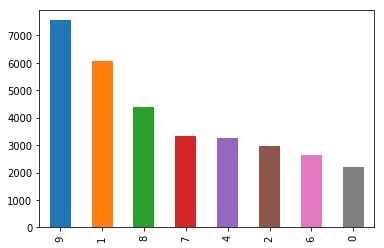

In [80]:
df.offer_id.value_counts().plot(kind='bar')
plt.show()

In [81]:
df.columns

Index(['user_id', 'offer_id', 'age', 'gender', 'income', 'join_year',
       'join_month', 'join_day', 'difficulty', 'duration', 'offer_type',
       'reward', 'email', 'mobile', 'social', 'web', 'time_received',
       'time_viewed', 'time_completed', 'offer_expire', 'success', 'effective',
       'failed', 'time_spent', 'amount'],
      dtype='object')

In [83]:
df.isnull().sum()

user_id              0
offer_id             0
age                  0
gender            3058
income            3058
join_year            0
join_month           0
join_day             0
difficulty           0
duration             0
offer_type           0
reward               0
email                0
mobile               0
social               0
web                  0
time_received        0
time_viewed          0
time_completed       0
offer_expire         0
success              0
effective            0
failed               0
time_spent           0
amount               0
dtype: int64

In [84]:
df.shape, df.user_id.nunique()

((32396, 25), 11568)

Since our goal is to segment the customers we need to do the below:

- Extract as much variables as possible from the offers
- Have the dataframe where each line is a customer
- Fill the missing values in age and income
- Conduct an unpservised learning customer segmentation

In [89]:
# Number of offers succesful and effective by person
df_1 = df.groupby(['user_id', 'offer_id'])['success', 'effective'].sum().reset_index().rename(columns={'success':'num_succ', 'effective':'num_effect'})
df_1.head()

,user_id,offer_id,num_succ,num_effect
0,0,0,0,1
1,0,1,0,1
2,0,6,0,1
3,1,4,0,1
4,1,9,0,1


In [82]:
df.head()

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,...,web,time_received,time_viewed,time_completed,offer_expire,success,effective,failed,time_spent,amount
0,5438,6,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,132,19.89
7,2537,8,65,M,53000.0,2018,2,9,5,5,...,1,0,0.0,60.0,5,0,1,0,60,9.54
10,3403,7,64,M,100000.0,2017,9,9,10,7,...,0,0,102.0,510.0,7,0,1,0,180,32.31
11,3403,7,64,M,100000.0,2017,9,9,10,7,...,0,0,102.0,510.0,7,0,1,0,216,28.12
12,3403,7,64,M,100000.0,2017,9,9,10,7,...,0,0,102.0,510.0,7,0,1,0,258,21.75


In [92]:
# Total and average money spent by customer on each offer
df_2 = df.groupby(['user_id', 'offer_id']).amount.agg(['sum', 'mean']).reset_index()
# .rename(columns={'success':'num_succ', 'effective':'num_effect'})
df_2

DataError: No numeric types to aggregate